Parts of this notebook are taken from Andre Karpathy: https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib1.ipynb
and have been modified. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
from matplotlib.backends import backend_agg
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
# importing all of the normalizing flows. 
from nflib import utils
from nflib.MADE import *
from nflib.nets import MLP
from nflib.discrete_flow import *

## Generating the training data. A 2D Gaussian. 
Storing the data as variable "data" which will then be sampled from. 

In [3]:
def sample_quantized_gaussian_mixture(batch_size):
  """Samples data from a 2D quantized mixture of Gaussians.
  This is a quantized version of the mixture of Gaussians experiment from the
  Unrolled GANS paper (Metz et al., 2017).
  Args:
    batch_size: The total number of observations.
  Returns:
    Tensor with shape `[batch_size, 2]`, where each entry is in
      `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
      of Gaussians.
  """
  clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                       [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                       [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                       [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
  assignments = torch.distributions.OneHotCategorical(
      logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
  means = torch.matmul(assignments, torch.from_numpy(clusters).float())

  samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
  clipped_samples = torch.clamp(samples, -2.25, 2.25)
  quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
  return quantized_samples

In [4]:
batch_size, data_size, num_classes = 1024, 2, 91
data = sample_quantized_gaussian_mixture(1024)

## Generating an example onehot sample of the data:

Text(0.5, 1.0, 'Data Distribution')

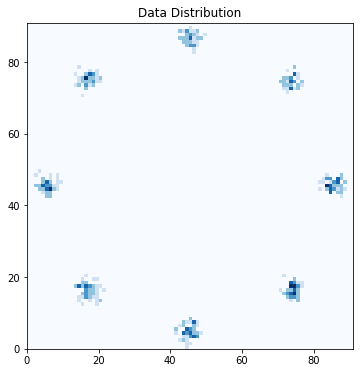

In [5]:
figsize = (6, 6)
fig = fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=num_classes)
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, num_classes, 0, num_classes],
             interpolation="nearest")
#fig.show()
ax.set_title("Data Distribution")


## Generating the model

In [6]:
class EmbeddingNetwork(nn.Module):
  """Autoregressive network which uniquely embeds each combination."""

  def __init__(self, input_shape, output_size=None):
    """Initializes Embedding network.
    Args:
      output_size: Embedding output dimension. When `None`, `output_size`
        defaults to `vocab_size`, which are used for loc/scale modular networks.
        Sinkhorn networks require `output_size` to be `vocab_size ** 2`.
    """
    super(EmbeddingNetwork, self).__init__()
    self.output_size = output_size
    data_size = input_shape[-2]
    num_classes = input_shape[-1]
    if self.output_size is None:
      self.output_size = num_classes
    self.embeddings = nn.ModuleList()
    for dim in range(1, data_size):
      # Make each possible history unique by converting to a base 10 integer.
      embedding_layer = nn.Embedding(
          num_classes ** dim,
          self.output_size)
      self.embeddings.append(embedding_layer)

  def forward(self, inputs, initial_state=None):
    """Returns Tensor of shape [..., data_size, output_size].
    Args:
      inputs: Tensor of shape [..., data_size, vocab_size].
      initial_state: `Tensor` of initial states corresponding to encoder output.
    """
    num_classes = inputs.shape[-1]
    sparse_inputs = torch.argmax(inputs, axis=-1)
    location_logits = [torch.zeros([sparse_inputs.shape[0], self.output_size])]
    for dim, embedding_layer in enumerate(self.embeddings, 1):
      powers = torch.pow(num_classes, torch.arange(dim)).unsqueeze(0)
      embedding_indices = torch.sum(  # (batch_size,)
          sparse_inputs[:, :dim] * powers, axis=1)
      location_logits.append(embedding_layer(embedding_indices))

    location_logits = torch.stack(location_logits, axis=1)
    return location_logits


In [7]:

temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
#flows = []

In [8]:
layer = EmbeddingNetwork([batch_size, data_size, num_classes], num_classes)    
disc_layer = DiscreteAutoregressiveFlow(layer, temperature, num_classes)
model = disc_layer
    
#model = DiscreteAutoFlowModel(flows)

## Converting into a proper probability distribution

In [9]:

base_log_probs = torch.tensor(torch.randn(data_size, num_classes), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)



/lustre/home/ayashas/mt/mt-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


epoch: 0 loss: 10.186023700749502
epoch: 100 loss: 8.298782746307552
epoch: 200 loss: 7.510354370577261
epoch: 300 loss: 7.224664193345234
epoch: 400 loss: 7.134498035535216
epoch: 500 loss: 7.105601985473186
epoch: 600 loss: 7.055416360730305
epoch: 700 loss: 7.00999439554289
epoch: 800 loss: 7.039519424317405
epoch: 900 loss: 7.054449629038572


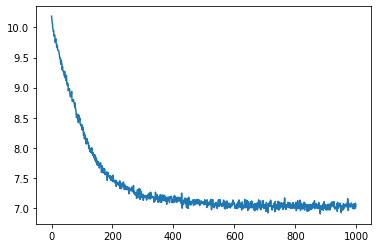

In [10]:
epochs = 1000
learning_rate = 0.01
print_loss_every = epochs//10

#base_log_probs = torch.tensor( base.logits.detach().numpy() , requires_grad=True)

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    x = sample_quantized_gaussian_mixture(batch_size)
    x = F.one_hot(x, num_classes = num_classes).double()
    x = x.flip([-2])
    optimizer.zero_grad()
    zs = model.forward(x)
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    logprob = zs*base_log_probs_sm
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        #print(base_log_probs_[0])
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

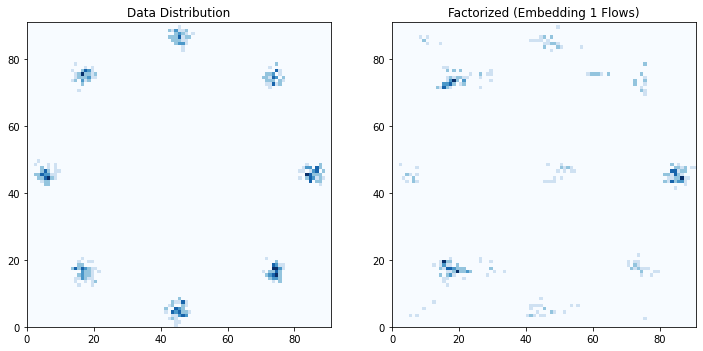

In [13]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([1024])
samples = model.reverse(samples)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()
figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=num_classes)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, num_classes, 0, num_classes],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=num_classes)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, num_classes, 0, num_classes],
         interpolation="nearest")
fig.show()
